<a href="https://colab.research.google.com/github/ajzalfaizal/Team-Research-Group-A177/blob/main/CNN_for_Brain_Tumour_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Upload your kaggle.json
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle (4).json


{'kaggle (4).json': b'{"username":"ajufaizal","key":"e4898331bf66276cef66552c7d1b5643"}'}

In [7]:
# Set up Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [8]:
#!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
#!unzip -q brain-tumor-mri-dataset.zip


In [9]:
!ls


 brain_resnet18.pth	      'kaggle (1).json'  'kaggle (4).json'   Testing
 brain_tumor_model.pth	      'kaggle (2).json'   kaggle.json	     Training
 brain-tumor-mri-dataset.zip  'kaggle (3).json'   sample_data


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # Define loss and optimizer
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [11]:
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image

In [12]:


# Preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load the TRAINING dataset
dataset = datasets.ImageFolder("Training", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Print class names
print("Classes:", dataset.classes)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


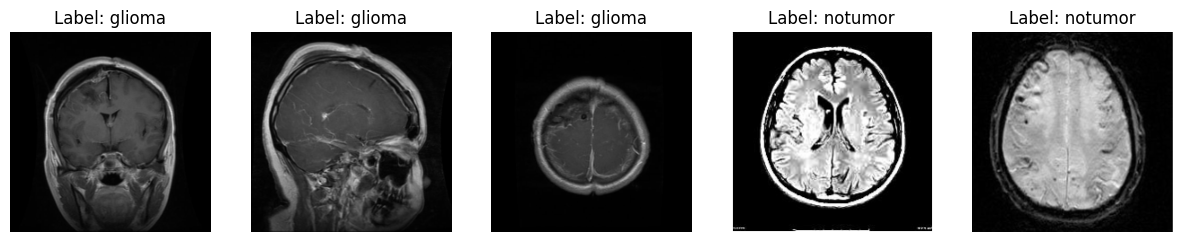

In [13]:
# Show a batch of images
import matplotlib.pyplot as plt

images, labels = next(iter(dataloader))
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img = images[i].permute(1, 2, 0) * 0.5 + 0.5
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {dataset.classes[labels[i]]}")
    axes[i].axis('off')
plt.show()

In [14]:
#Simple CNN Model in PyTorch

class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, len(dataset.classes))  # number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B, 16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # (B, 32, 56, 56)
        x = x.view(-1, 32 * 56 * 56)          # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BrainTumorCNN()
print(model)


BrainTumorCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [15]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")


In [ ]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Training Accuracy: {100 * correct / total:.2f}%")


In [ ]:
torch.save(model.state_dict(), "brain_tumor_model.pth")

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder("Training", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")
print("Classes:", dataset.classes)


In [ ]:
# Load ResNet18 pretrained on ImageNet
resnet = models.resnet18(pretrained=True)

# Freeze all layers (optional for faster training)
for param in resnet.parameters():
    param.requires_grad = False

# Replace the final layer for 4 output classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 4)  # 4 = number of classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)  # only fine-tune final layer

In [ ]:
epochs = 5

for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


In [ ]:
torch.save(resnet.state_dict(), "brain_resnet18.pth")
print("✅ Brain MRI model saved successfully.")

In [ ]:
# Set model to evaluation mode
resnet.eval()

# Collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Brain MRI")
plt.show()

# Print classification report
print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


In [ ]:
!pip install torchcam # for Grad-CAM

In [ ]:
#Grad-CAM start from here

# Attach GradCAM to the last conv layer of ResNet


cam_extractor = GradCAM(resnet, target_layer='layer4')
resnet.eval()
